In [1]:
import pandas as pd
import numpy as np
from lshash import LSHash
import random as rd

def input():

    # file input
    data = pd.read_csv('trade.csv', index_col=['uid'])

    # make groups
    grouped = data.groupby(['vipno', 'pluno'], as_index = False)
    
    # make sum
    grouped = grouped['amt'].agg(np.sum)

    # change type
    grouped[['vipno', 'pluno']] = grouped[['vipno', 'pluno']].astype('object')

    # merge
    total = pd.DataFrame(0, index=list(set(data['pluno'])), columns=list(set(data['vipno'])), dtype='int64')
    for index, row in grouped.iterrows():
       total.at[row['pluno'], row['vipno']] = int(np.floor(row['amt'] + 0.5))

    # convert
    data_array = total.as_matrix()
    return data_array, total, total.shape

def knn(data_array, data, hash_size_input, data_shape, vipno_pos, k):

    # init LSHash
    lsh = LSHash(hash_size=hash_size_input, input_dim=data_shape[0])

    # index
    for col_index in range(data_shape[1]):
        lsh.index(data_array[:, col_index], extra_data=data.columns[col_index])

    # calculate and output
    result = []
    for res in lsh.query(data_array[:, vipno_pos], num_results=k + 1, distance_func='euclidean'):
        result.append(res[0][1])

    return result[1:]

In [2]:
import math
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

def evaluate_dbscan():
    
    # data input
    data_array, data, data_shape = input()
    data_transposed = data.transpose()
    data_array_transposed = data_array.transpose() 

    range_silhouette_avg = [] 

    # get the result of DBSCAN
    eps_range = range(60,320)
    for eps in eps_range:

        # init dbscan set
        db = DBSCAN(eps=eps,min_samples=4)
        clusterer = db.fit(data_transposed)
        cluster_labels = clusterer.labels_

        # same as q2
        if cluster_labels.tolist().count(0) < 1:
            # all labels are -1
            print 'All data is ragard as noise'

        else:
            silhouette_avg = silhouette_score(data_transposed, cluster_labels)
            range_silhouette_avg.append(silhouette_avg)
            # print 'For eps = %d, The average silhouette_score is: %f' %(eps, silhouette_avg)

    # draw the chart
    plt.plot(eps_range, range_silhouette_avg, 'bx-')
    plt.title('Silhouette_score-eps line-chart')
    plt.xlabel('eps')
    plt.ylabel('silhouette_score')
    plt.legend()
    plt.show()

def validate(eps):

    # data input
    data_array, data, data_shape = input()
    data_transposed = data.transpose()
    data_array_transposed = data_array.transpose() 

    # get a random vipno to use
    vipno_pos = rd.randint(0, data_shape[1])

    # get the result of DBSCAN
    db = DBSCAN(eps=eps,min_samples=2)
    clusterer = db.fit(data_transposed)
    cluster_labels = clusterer.labels_

    # make a dictionary to index the cluster
    labels_dic = pd.DataFrame(np.row_stack((data_transposed.index, cluster_labels))) 
    labels_dic = labels_dic.transpose().set_index(labels_dic.transpose()[0])

    # get result of KNN, and compare
    for scale in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
        for k in [1, 2, 3, 4, 5]:

            # get the result of KNN
            hash_size = int(data_shape[1] * scale)
            results = knn(data_array, data, hash_size, data_shape, vipno_pos, k)

            if len(results) < 1:
                print 'For eps = %d, hash_size = %d, k = %d: no result from KNN.\n' %(eps, hash_size, k)

            else:
                print 'For eps = %d, hash_size = %d, k = %d, vipno_input = %d:' %(eps, hash_size, k, results[0])

                # cluster of the vipno itself
                cluster = labels_dic.loc[results[0]][1]

                # and compare
                for result in results[1:]:
                    cluster_result = labels_dic.loc[results[0]][1]
                    print 'vipno_output: %d, result: %s' %(result, 'same' if cluster==cluster_result else 'not same.' )

                print''


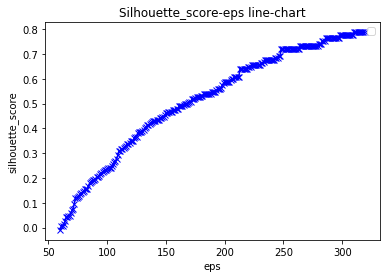

For eps = 310, hash_size = 2, k = 1, vipno_input = 1595132332932:

For eps = 310, hash_size = 2, k = 2, vipno_input = 1590151544861:
vipno_output: 1593140967467, result: same

For eps = 310, hash_size = 2, k = 3, vipno_input = 2900000549289:
vipno_output: 1591011326672, result: same
vipno_output: 1590151470542, result: same

For eps = 310, hash_size = 2, k = 4, vipno_input = 2900000549289:
vipno_output: 1591011326672, result: same
vipno_output: 1590151470542, result: same
vipno_output: 1598140121611, result: same

For eps = 310, hash_size = 2, k = 5, vipno_input = 1598140121611:
vipno_output: 1595142205462, result: same
vipno_output: 1591140691788, result: same
vipno_output: 1594140467704, result: same
vipno_output: 1590151300269, result: same

For eps = 310, hash_size = 14, k = 1: no result from KNN.

For eps = 310, hash_size = 14, k = 2: no result from KNN.

For eps = 310, hash_size = 14, k = 3: no result from KNN.

For eps = 310, hash_size = 14, k = 4: no result from KNN.

For eps =

In [3]:
if __name__ == '__main__':

    evaluate_dbscan()

    validate(310)

    #for eps in range(50,80):
    #    validate(eps)